In [1]:
import os
import torch
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.preprocessing import MinMaxScaler
from typing import Dict, Tuple, Optional, List

In [2]:
os.chdir('..') # change working directory to root

In [3]:
from agents.td3 import TD3
from agents.d3qn import D3QN
from mdp.mimic_iii.reward_functions.abstract_reward_function import AbstractRewardFunction
from mdp.mimic_iii.reward_functions.factory import Factory as RewardFnFactory
from mdp.mimic_iii.action_spaces.discrete import Discrete as DiscreteActionSpace
from mdp.mimic_iii.state_spaces.sparse_autoencoder import SparseAutoEncoder as MimicIIISparseAutoEncoderStateSpace
from ope.behavior_policies.kmeans_sarsa import KMeansSarsa
from utilities import mimic_iii_funcs
from utilities.device_manager import DeviceManager

In [4]:
# reward function details dict
reward_fn_details_dict = {
    'sparse': {
        'mlflow_base_path': '<your_base_path>/mimic-iii_reward_fn_eval/vm/mlruns',
        'state_space_run_id': 'd5233d8c966846b0b01406a162c26fe7',
        'behavior_policy_run_id': '97629e709d7f45ec851200c6b0d497df',
        'd3qn_run_id': '5944007810ef4e318106533adbd6ccb6',
        'd3qn_magic_run_id': '85de6b80c8374e489bb49164bcbf29a5',
        'ddpg_run_id': 'cba965ed952945a1a0d9660d807cf2a0',
        'ddpg_magic_run_id': 'f835cde18011478693931ecc0247df63',
    },
    'wu': {
        'mlflow_base_path': '<your_base_path>/mimic-iii_reward_fn_eval/0/mlruns',
        'state_space_run_id': 'd5233d8c966846b0b01406a162c26fe7',
        'behavior_policy_run_id': '6dd75e96646b45938f225f3964705324',
        'd3qn_run_id': '5d140bdb06e344bd888876561f010f0e',
        'd3qn_magic_run_id': 'fd3f75118286426f88ca127246e33cda',
        'ddpg_run_id': '67c02a6bab0b4d74aadf585f7c8edd87',
        'ddpg_magic_run_id': '18ed010dada041f79639230d54ca5db7',
    },
    'yong': {
        'mlflow_base_path': '<your_base_path>/mimic-iii_reward_fn_eval/0/mlruns',
        'state_space_run_id': 'd5233d8c966846b0b01406a162c26fe7',
        'behavior_policy_run_id': 'ecac4334f1994260b2bcd420b671c53a',
        'd3qn_run_id': '8f098fb13a5b41da9e77dac2ae13d321',
        'd3qn_magic_run_id': '29ad84ac64ed4ab98f7e10488887f301',
        'ddpg_run_id': '30cccf0e3c2c4ffaa1a9ea1c2bf23972',
        'ddpg_magic_run_id': '7ecad48fb0e04388b048d183b195e5f8',
    },
    'raghu': {
        'mlflow_base_path': '<your_base_path>/mimic-iii_reward_fn_eval/1/mlruns',
        'state_space_run_id': 'd5233d8c966846b0b01406a162c26fe7',
        'behavior_policy_run_id': '17d5de3272cb4e2892e6e438d22c2af4',
        'd3qn_run_id': '9a5d00e3454840499ce4697fa6bf472c',
        'd3qn_magic_run_id': 'd2584eef61284bc4bc9d57402927b750',
        'ddpg_run_id': 'da45045dfb1042d1a21a06360ca55239',
        'ddpg_magic_run_id': '01c5faa0f8ee4a5b9cb08a712060dc0e',
    },
    'peng': {
        'mlflow_base_path': '<your_base_path>/mimic-iii_reward_fn_eval/1/mlruns',
        'state_space_run_id': 'd5233d8c966846b0b01406a162c26fe7',
        'behavior_policy_run_id': '1e6330b7604f4aad8da905239c1b5070',
        'd3qn_run_id': '37d3ea87328d4c94a75c5d6e0011495a',
        'd3qn_magic_run_id': '68161afeb1ff41bbbc795f91e6a42c5b',
        'ddpg_run_id': 'b008b48ce39d4847ae2d377b4cbb91ba',
        'ddpg_magic_run_id': '2d6c08b95c8e40c2a6a0473a3b12f737',
        'reward_fn_run_id': '211c5a3c31f147f38d63b6b357a7b610',
    },
}

In [5]:
def load_split_agent_test_data_reward_min_max(split_: int, reward_fn_name_: str, reward_fn: AbstractRewardFunction) -> Tuple[float, float]:
    # load and preprocess mimic data
    discrete_mimic_df = mimic_iii_funcs.load_standardized_mimic_data(split_, reward_fn.raw_data_columns)
    if reward_fn_name_ != 'peng':
        reward_fn.update_rewards(discrete_mimic_df)  # scale rewards
        discrete_mimic_df = mimic_iii_funcs.drop_all_raw_data_columns(discrete_mimic_df)
    continuous_mimic_df = discrete_mimic_df.copy()
    discrete_mimic_df, discrete_min_max_scaler, _ = mimic_iii_funcs.preprocess_mimic_data(discrete_mimic_df, 'iql_discrete')
    continuous_mimic_df, continuous_min_max_scaler, action_min_max_scaler = mimic_iii_funcs.preprocess_mimic_data(continuous_mimic_df, 'ddpg_cont')
    if reward_fn_name_ == 'peng':
        reward_fn.update_rewards(discrete_mimic_df)  # scale rewards
        reward_fn.update_rewards(continuous_mimic_df)
    max_reward_ = discrete_mimic_df['r:reward'].max().item()
    min_reward_ = discrete_mimic_df['r:reward'].min().item()
    return min_reward_, max_reward_

def load_reward_fn(reward_fn_name_: str, reward_fn_results_dict_: Dict[str, str], split_: int) -> AbstractRewardFunction:
    reward_fn_ = RewardFnFactory.create(reward_fn_name_)
    if reward_fn_name_ == 'peng':
        peng_run_id = reward_fn_results_dict_['reward_fn_run_id']
        reward_fn_.load(f'runs:/{peng_run_id}/split_{split_}')
    return reward_fn_

def load_magic_results_for_plots(tracking_uri: str, run_id: str) -> pd.DataFrame:
    client = mlflow.MlflowClient(tracking_uri=tracking_uri)
    metric_history = client.get_metric_history(run_id, 'magic')
    magic_vals = [metric.value for metric in metric_history]
    result_dict = dict(j_step_weight=list(), j_step=list(), magic_val=list())
    for j_step in {3, 5, 7, 10, float('inf'), -1}:
        metric_history = client.get_metric_history(run_id, f'j_step_{j_step}')
        for i, metric in enumerate(metric_history):
            result_dict['j_step_weight'].append(metric.value)
            result_dict['j_step'].append(j_step)
            result_dict['magic_val'].append(magic_vals[i])
    return pd.DataFrame.from_dict(result_dict)

def load_magic_results_for_table(tracking_uri: str, run_id: str) -> Dict[str, float]:
    client = mlflow.MlflowClient(tracking_uri=tracking_uri)
    metric_history = client.get_metric_history(run_id, 'magic')
    magic_vals = [metric.value for metric in metric_history]
    magic_mean, magic_std = np.mean(magic_vals), np.std(magic_vals)
    result_dict = dict(magic_mean=magic_mean, magic_std=magic_std)
    for j_step in {3, 5, 7, 10, float('inf'), -1}:
        metric_history = client.get_metric_history(run_id, f'j_step_{j_step}')
        j_step_vals = [metric.value for metric in metric_history]
        j_step_mean, j_step_std = np.mean(j_step_vals), np.std(j_step_vals)
        result_dict[f'j_step_{j_step}_mean'] = j_step_mean
        result_dict[f'j_step_{j_step}_std'] = j_step_std
    return result_dict

def do_magic_result_plot(results_df: pd.DataFrame):
    f, (magic_ax, d3qn_weight_ax, ddpg_weight_ax) = plt.subplots(3, 1, figsize=(10, 25))
    sns.boxplot(results_df, x='agent', y='magic_val', ax=magic_ax)
    magic_ax.set_title('MAGIC Policy Estimates')
    d3qn_result_view = results_df[results_df.agent == 'd3qn']
    sns.barplot(d3qn_result_view, x='j_step', y='j_step_weight', ax=d3qn_weight_ax)
    d3qn_weight_ax.set_title('D3QN Weights')
    ddpg_result_view = results_df[results_df.agent == 'ddpg']
    sns.barplot(ddpg_result_view, x='j_step', y='j_step_weight', ax=ddpg_weight_ax)
    ddpg_weight_ax.set_title('DDPG Weights')
    f.tight_layout()
    plt.show()

def extract_and_plot_magic_results(reward_fn_name: str, reward_fn_details_dict_: Dict[str, Dict[str, str]]):
    reward_fn_results_dict = reward_fn_details_dict_[reward_fn_name]
    mlflow.set_tracking_uri(reward_fn_results_dict['mlflow_base_path'])
    min_rewards, max_rewards = list(), list()
    for split in range(10):
        reward_fn = load_reward_fn(reward_fn_name, reward_fn_results_dict, split)
        min_reward, max_reward = load_split_agent_test_data_reward_min_max(split, reward_fn_name, reward_fn)
        min_rewards.append(min_reward)
        max_rewards.append(max_reward)
    d3qn_magic_result_df = load_magic_results_for_plots(reward_fn_results_dict['mlflow_base_path'], reward_fn_results_dict['d3qn_magic_run_id'])
    d3qn_magic_result_df['agent'] = 'd3qn'
    ddpg_magic_result_df = load_magic_results_for_plots(reward_fn_results_dict['mlflow_base_path'], reward_fn_results_dict['ddpg_magic_run_id'])
    ddpg_magic_result_df['agent'] = 'ddpg'
    result_df = pd.concat((d3qn_magic_result_df, ddpg_magic_result_df)).reset_index()
    result_df['min_reward'] = min_rewards * (result_df.shape[0] // 10)
    result_df['max_reward'] = max_rewards * (result_df.shape[0] // 10)
    do_magic_result_plot(result_df)
    
def print_table_from_result_dict(result_dict: Dict[str, float], agent_name: str):
    print(f'{agent_name} Results:')
    print(f'Min Reward: {result_dict["mean_reward_min"]:.4f} +/- {result_dict["std_reward_min"]:.4f}')
    print(f'Max Reward: {result_dict["mean_reward_max"]:.4f} +/- {result_dict["std_reward_max"]:.4f}')
    print(f'MAGIC: {result_dict["magic_mean"]:.4f} +/- {result_dict["magic_std"]:.4f}')
    for j_step in {3, 5, 7, 10, float('inf'), -1}:
        j_step_str = f'j_step_{j_step}'
        print(f'{j_step_str}: {result_dict[f"{j_step_str}_mean"]:.4f} +/- {result_dict[f"{j_step_str}_std"]:.4f}')
    
def extract_and_print_magic_result_table(reward_fn_name: str, reward_fn_details_dict_: Dict[str, Dict[str, str]]):
    reward_fn_results_dict = reward_fn_details_dict_[reward_fn_name]
    mlflow.set_tracking_uri(reward_fn_results_dict['mlflow_base_path'])
    min_rewards, max_rewards = list(), list()
    for split in range(10):
        reward_fn = load_reward_fn(reward_fn_name, reward_fn_results_dict, split)
        min_reward, max_reward = load_split_agent_test_data_reward_min_max(split, reward_fn_name, reward_fn)
        min_rewards.append(min_reward)
        max_rewards.append(max_reward)
    mean_reward_min, mean_reward_max = np.mean(min_rewards), np.mean(max_rewards)
    std_reward_min, std_reward_max = np.std(min_rewards), np.std(max_rewards)
    d3qn_result_dict = load_magic_results_for_table(reward_fn_results_dict['mlflow_base_path'], reward_fn_results_dict['d3qn_magic_run_id'])
    ddpg_result_dict = load_magic_results_for_table(reward_fn_results_dict['mlflow_base_path'], reward_fn_results_dict['ddpg_magic_run_id'])
    for result_dict in (d3qn_result_dict, ddpg_result_dict):
        result_dict['mean_reward_min'] = mean_reward_min
        result_dict['std_reward_min'] = std_reward_min
        result_dict['mean_reward_max'] = mean_reward_max
        result_dict['std_reward_max'] = std_reward_max
    print_table_from_result_dict(d3qn_result_dict, 'D3QN')
    print_table_from_result_dict(ddpg_result_dict, 'DDPG')
    

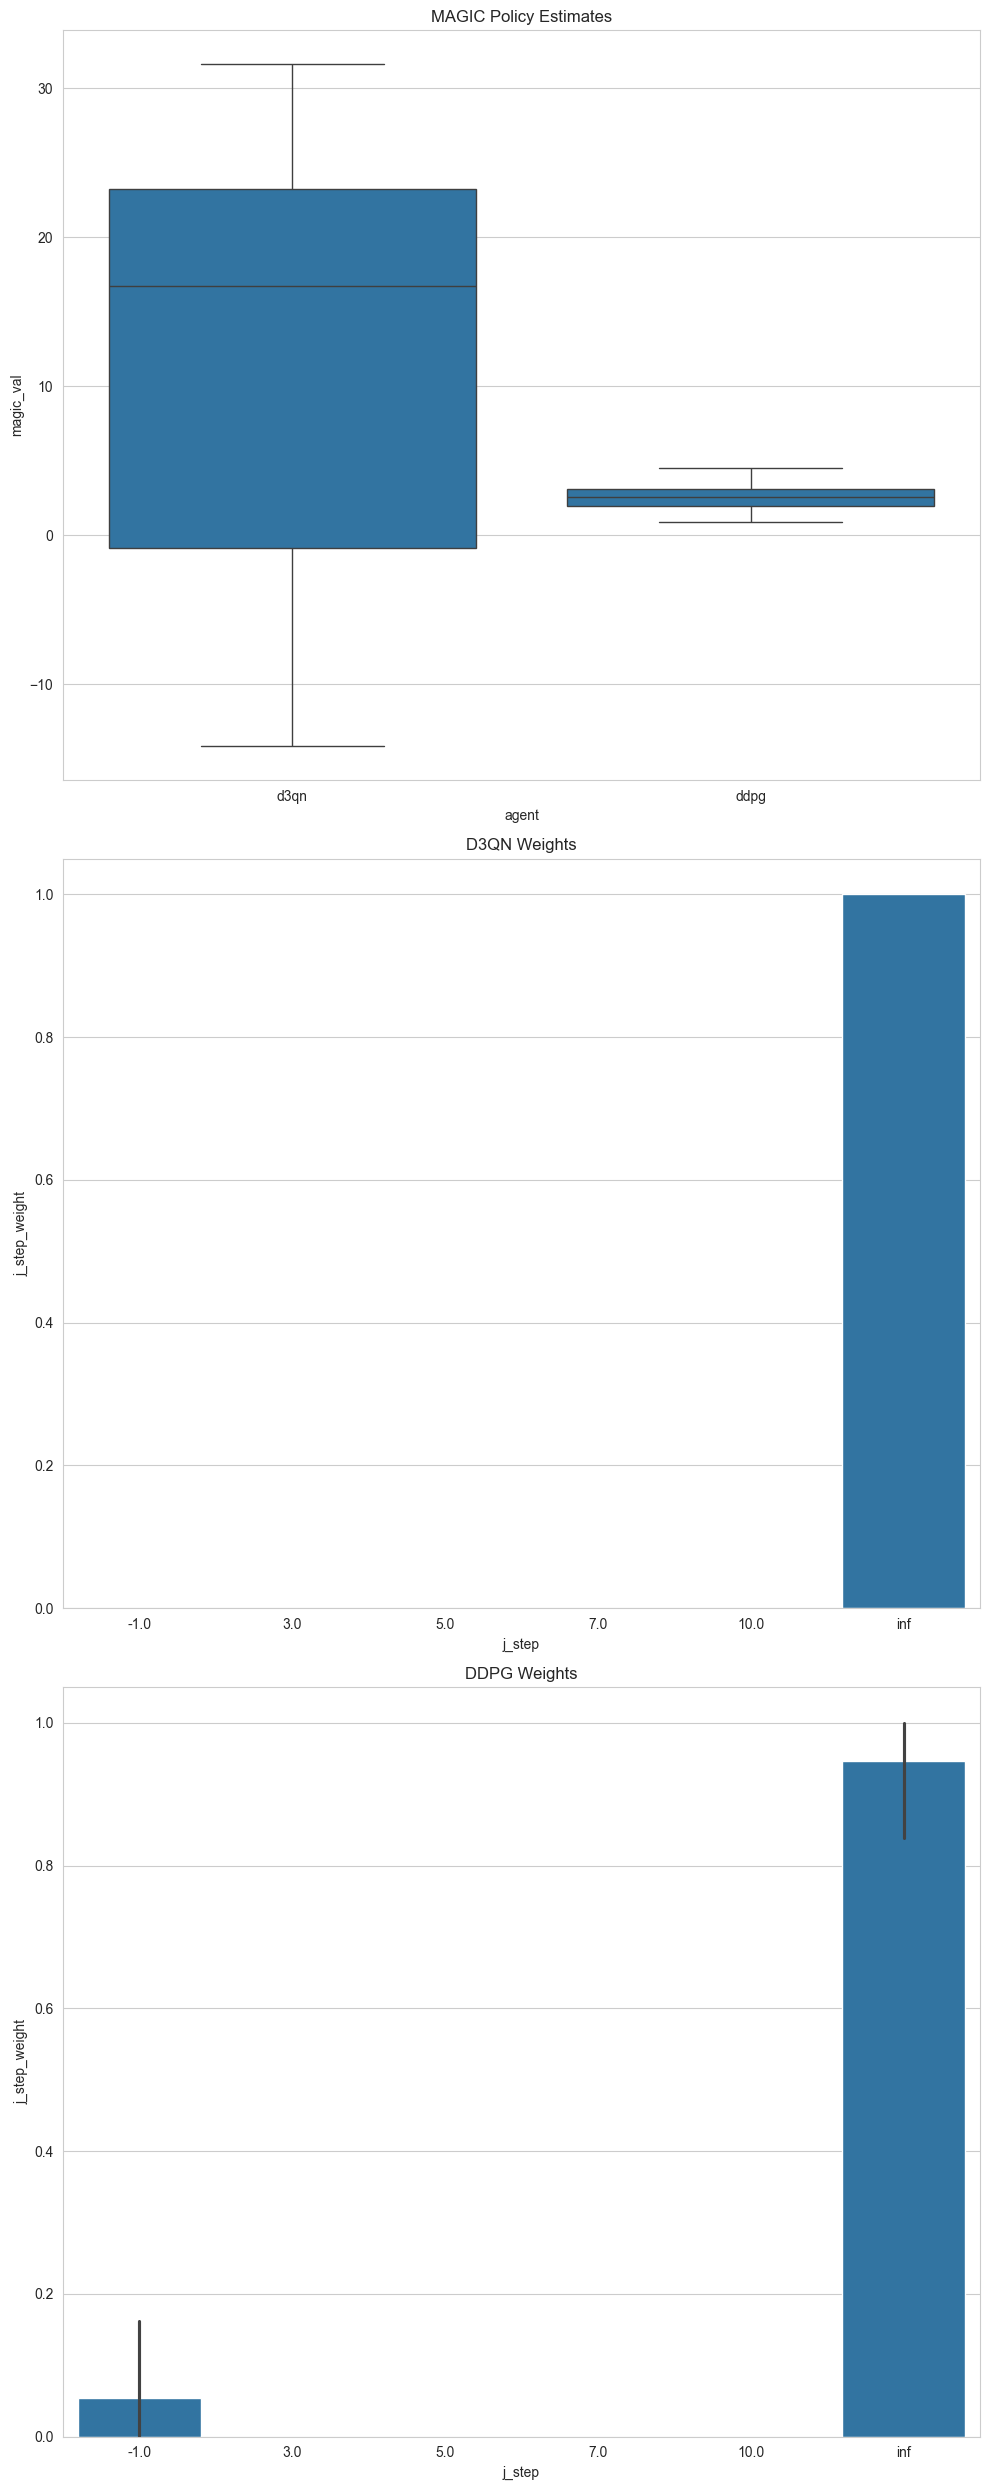

In [52]:
extract_and_plot_magic_results('sparse', reward_fn_details_dict)

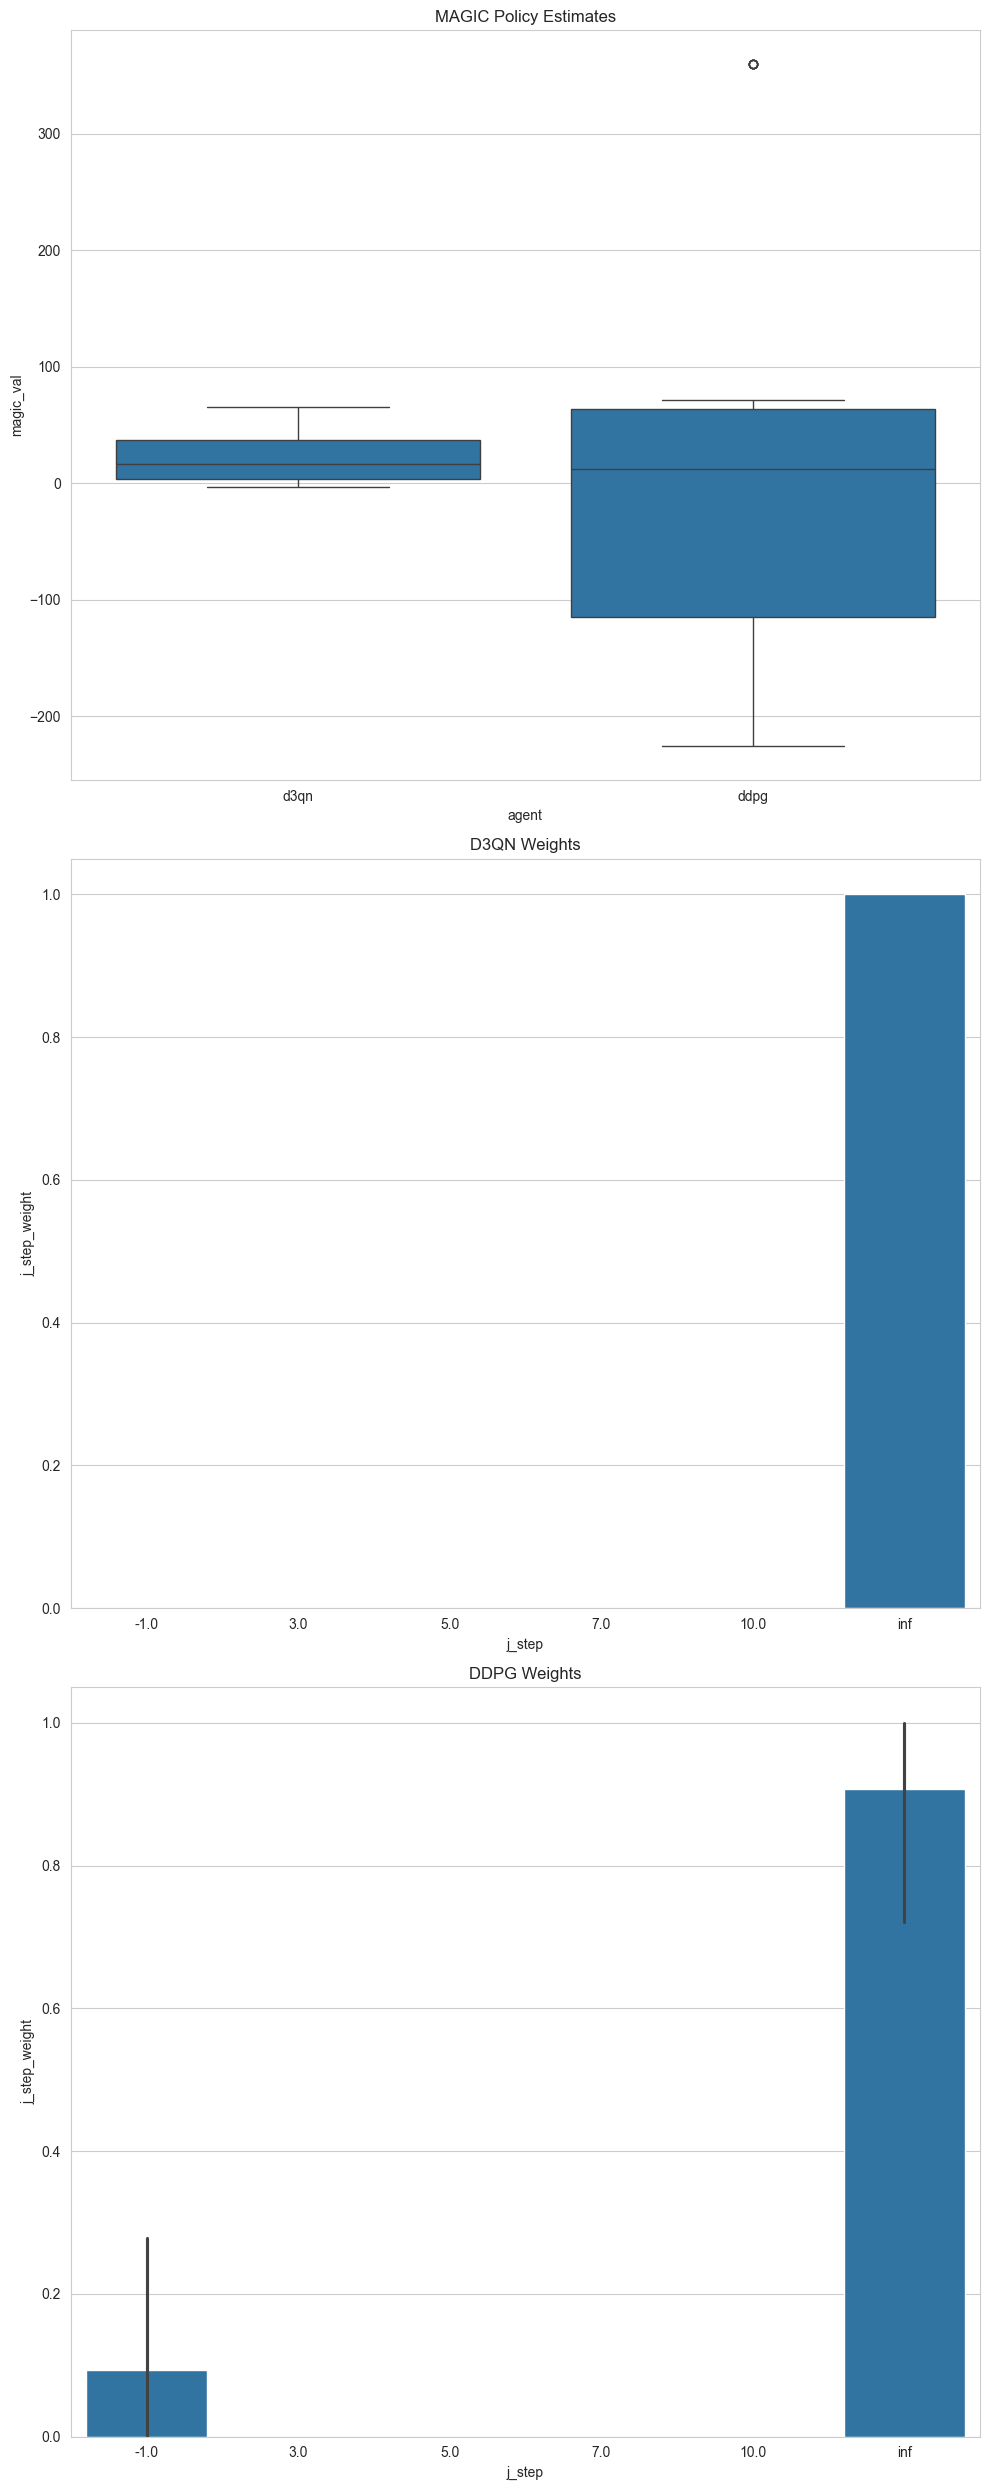

In [53]:
extract_and_plot_magic_results('wu', reward_fn_details_dict)

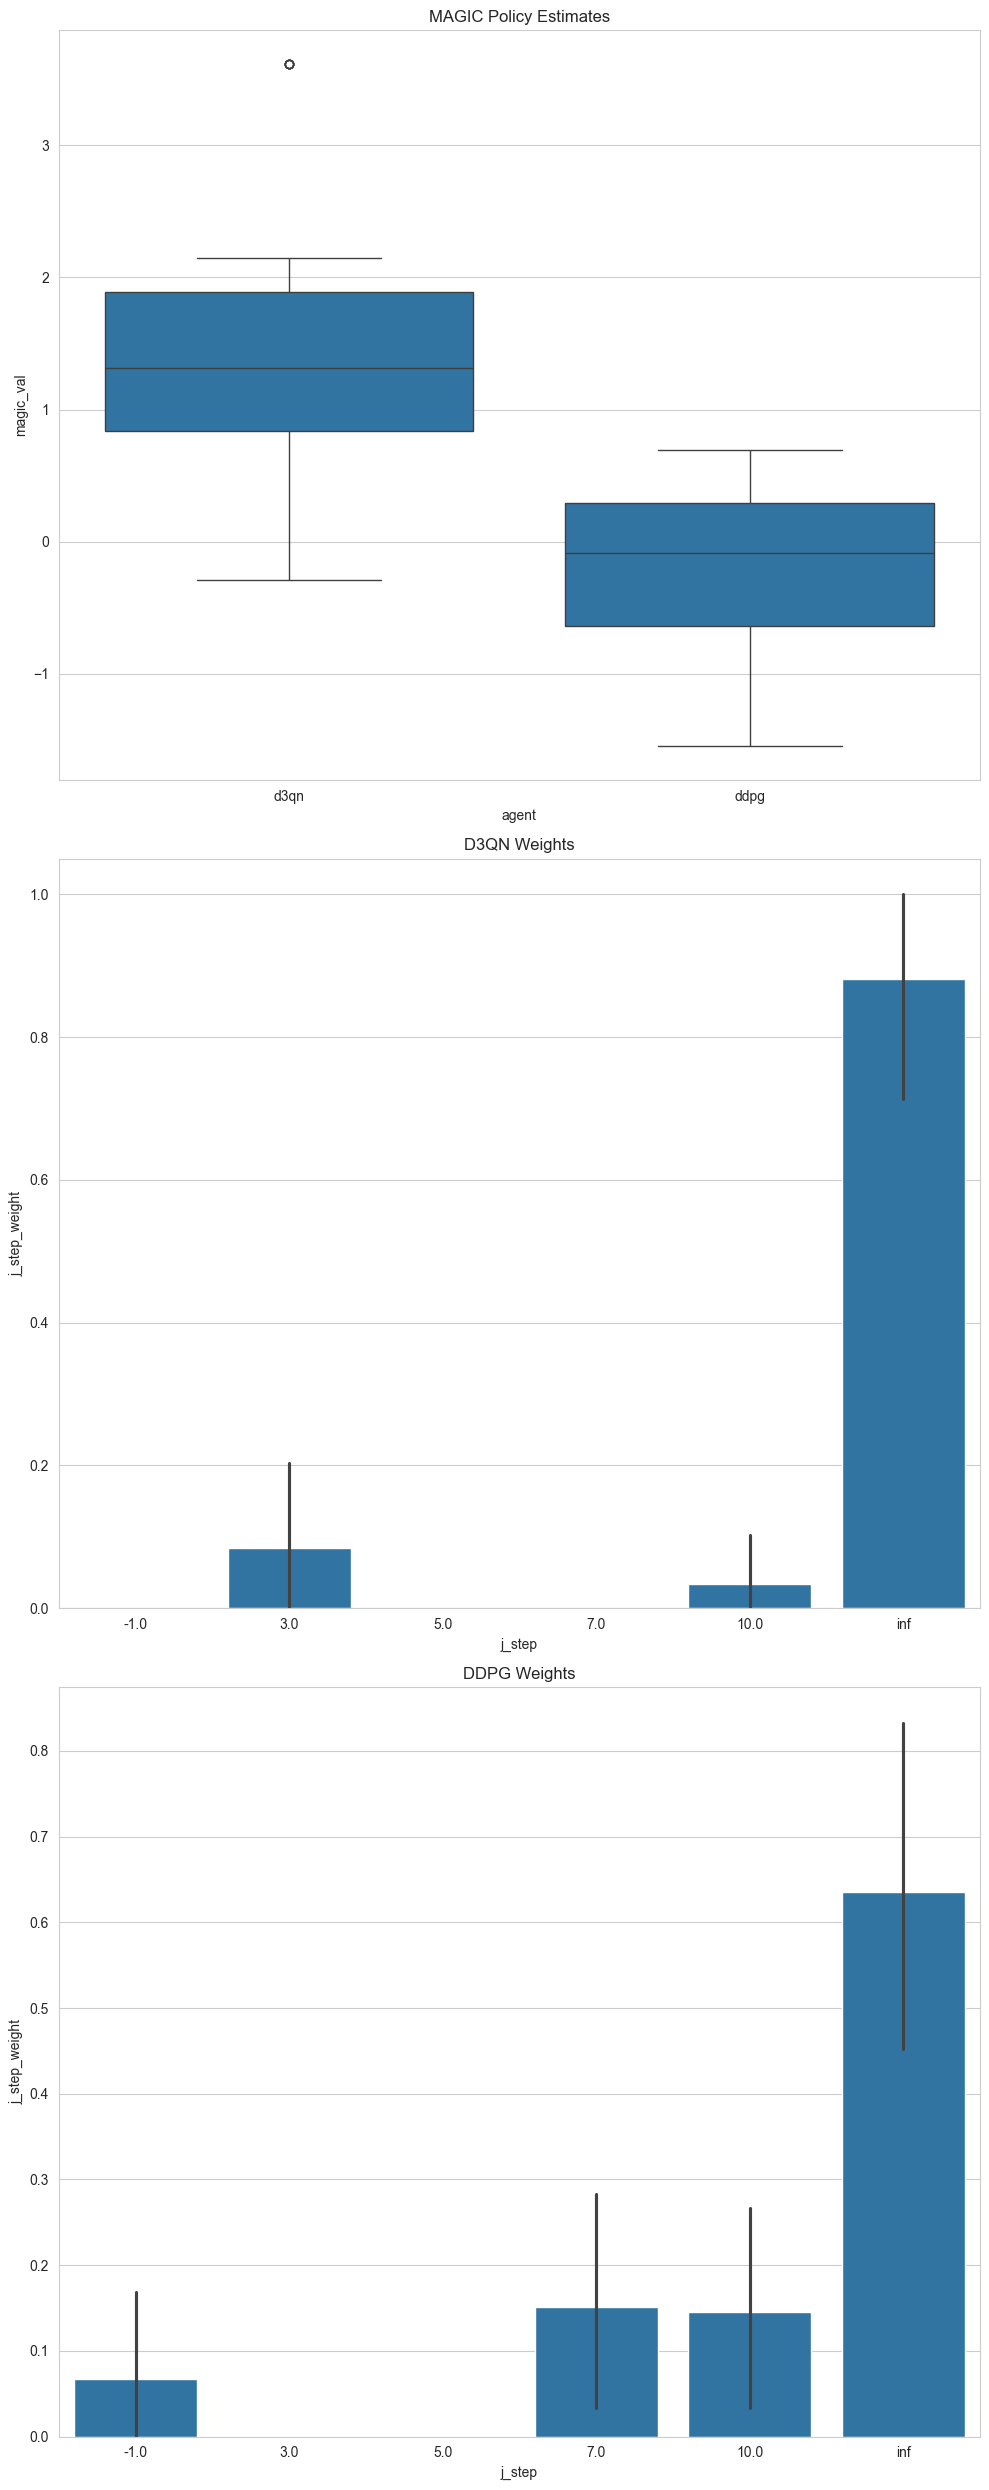

In [54]:
extract_and_plot_magic_results('yong', reward_fn_details_dict)

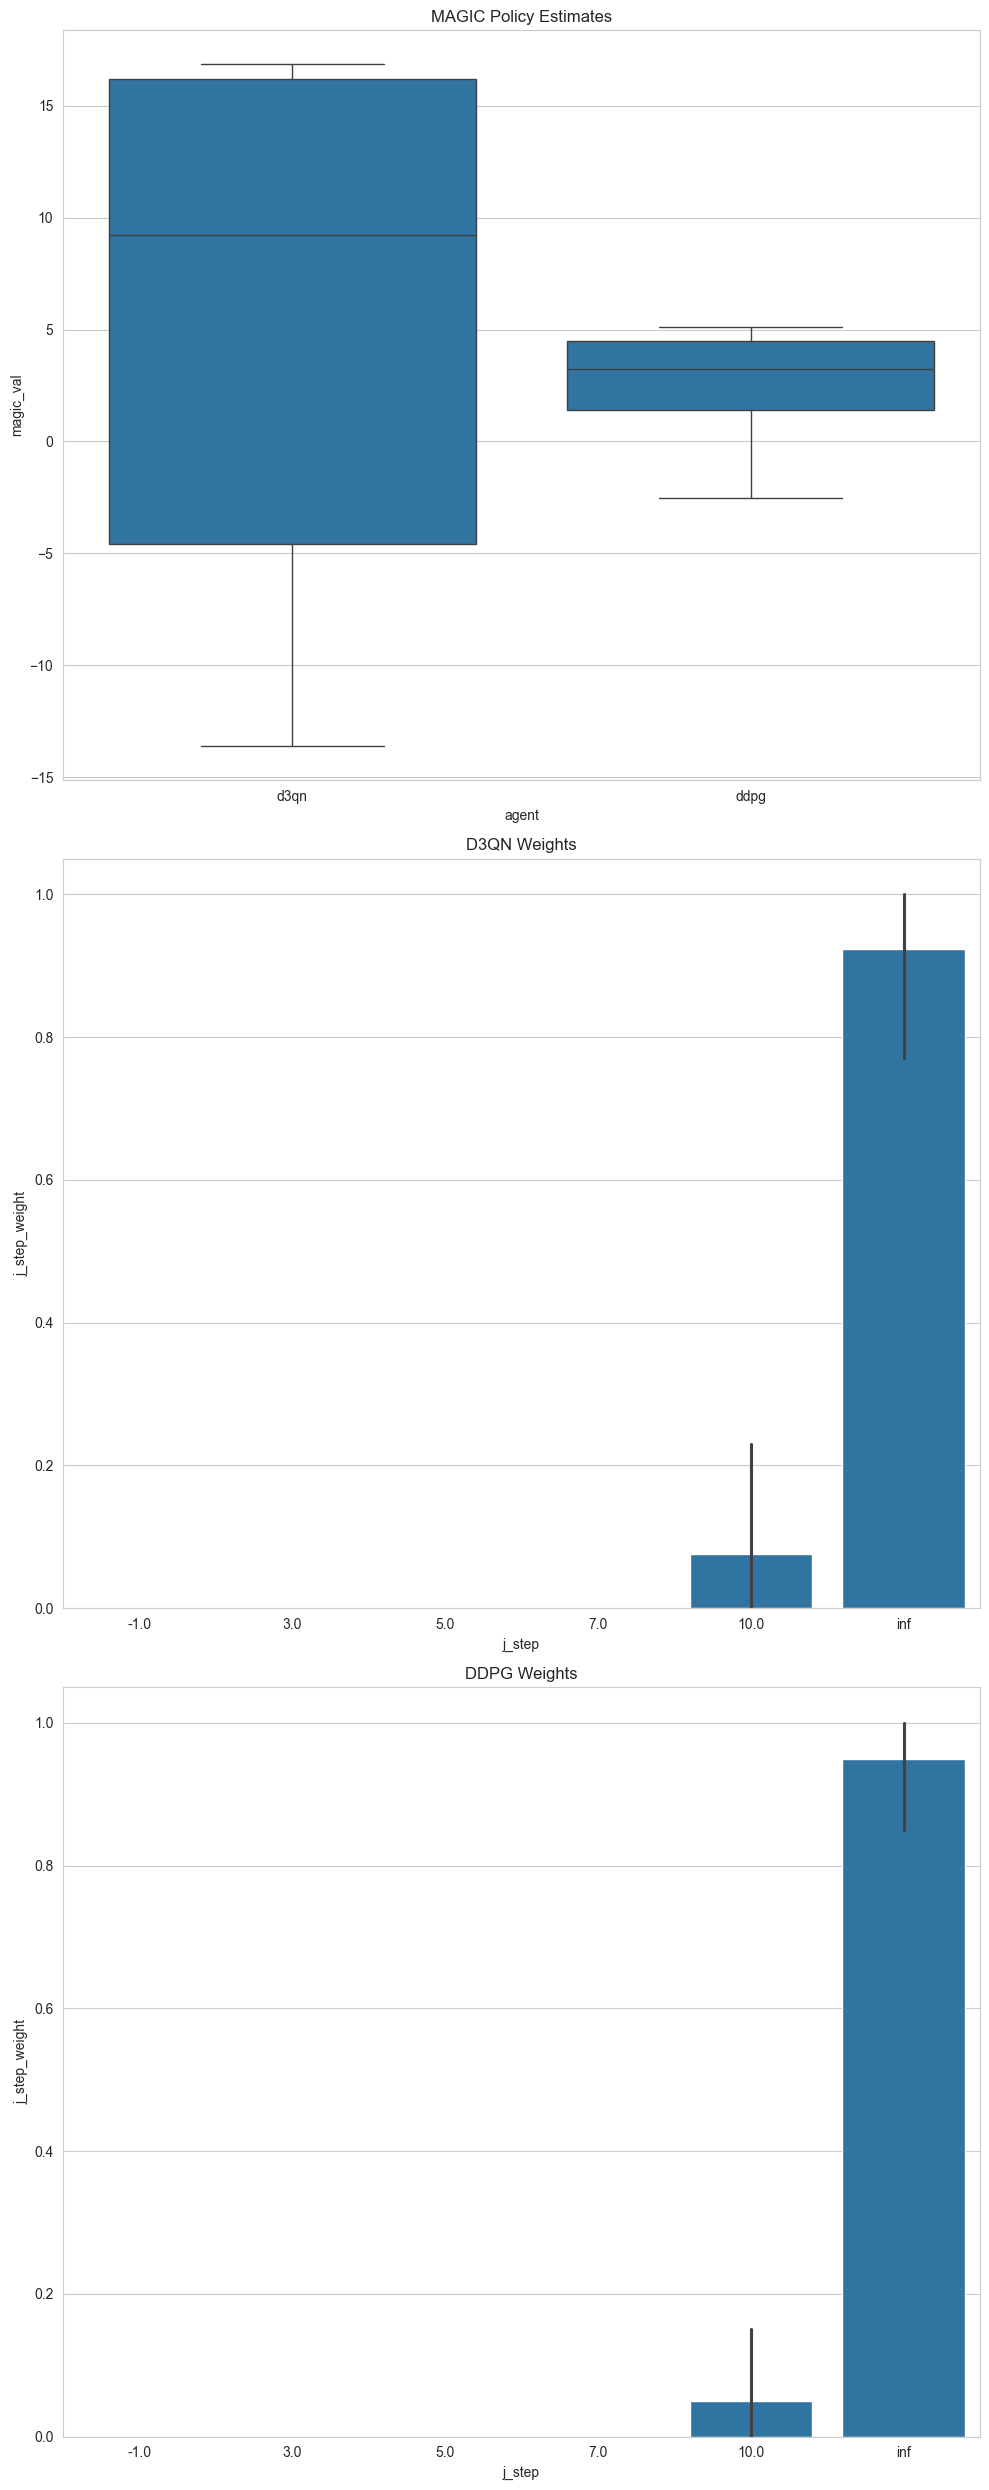

In [55]:
extract_and_plot_magic_results('raghu', reward_fn_details_dict)

2024/05/19 23:54:58 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/19 23:55:07 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/19 23:55:16 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/19 23:55:25 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/19 23:55:35 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/19 23:55:44 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/19 23:55:55 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/19 23:56:05 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed 

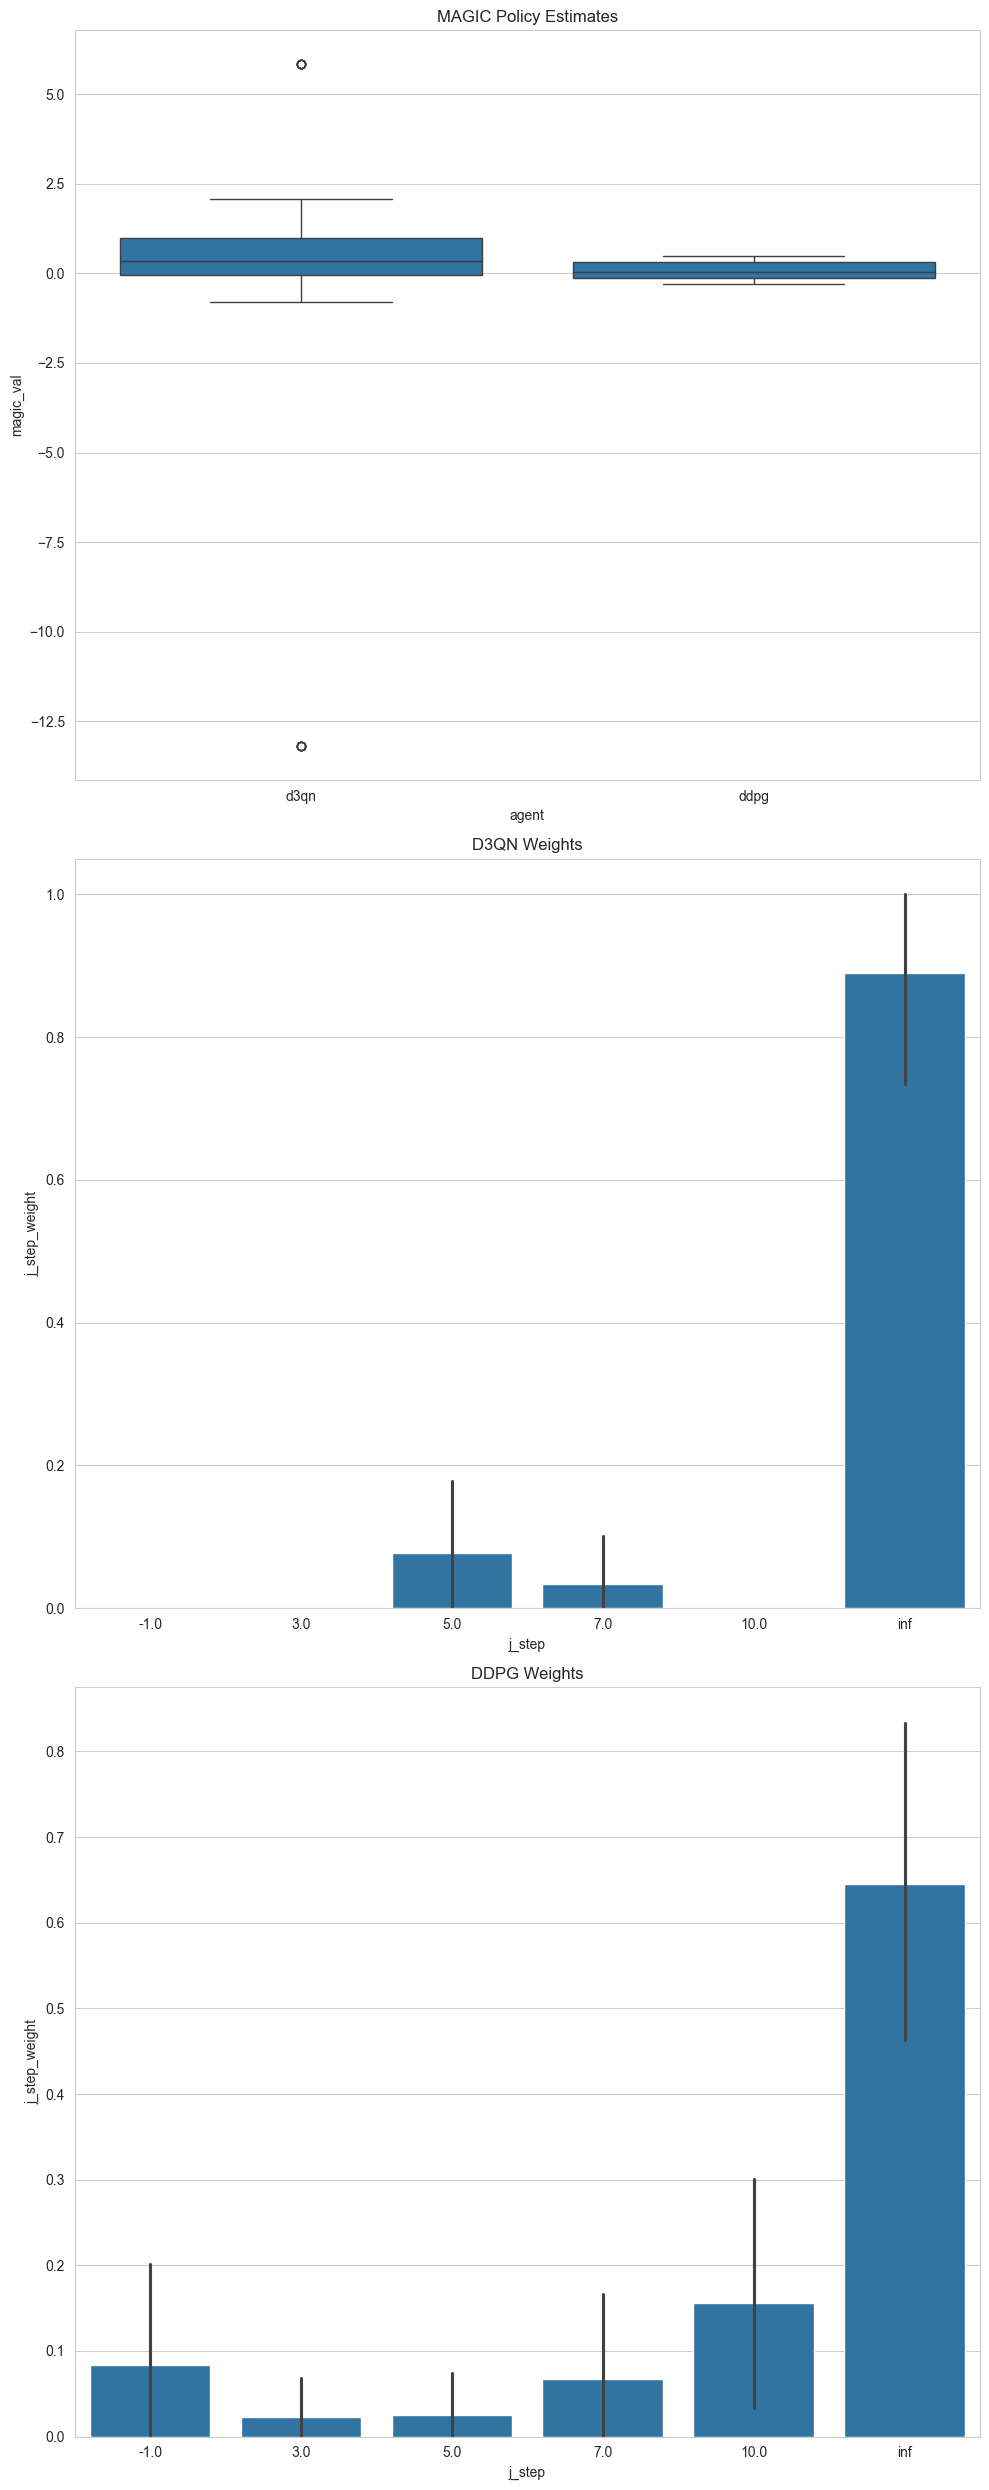

In [56]:
extract_and_plot_magic_results('peng', reward_fn_details_dict)

In [69]:
extract_and_print_magic_result_table('sparse', reward_fn_details_dict)

D3QN Results:
Min Reward: -15.0000 +/- 0.0000
Max Reward: 15.0000 +/- 0.0000
MAGIC: 12.7689 +/- 14.1580
j_step_3: 0.0000 +/- 0.0000
j_step_5: 0.0000 +/- 0.0000
j_step_7: 0.0000 +/- 0.0000
j_step_10: 0.0000 +/- 0.0000
j_step_inf: 1.0000 +/- 0.0000
j_step_-1: 0.0000 +/- 0.0000
DDPG Results:
Min Reward: -15.0000 +/- 0.0000
Max Reward: 15.0000 +/- 0.0000
MAGIC: 2.5864 +/- 0.9632
j_step_3: 0.0000 +/- 0.0000
j_step_5: 0.0000 +/- 0.0000
j_step_7: 0.0000 +/- 0.0000
j_step_10: 0.0000 +/- 0.0000
j_step_inf: 0.9462 +/- 0.1613
j_step_-1: 0.0538 +/- 0.1613


In [70]:
extract_and_print_magic_result_table('wu', reward_fn_details_dict)

D3QN Results:
Min Reward: -24.0000 +/- 0.0000
Max Reward: 24.0000 +/- 0.0000
MAGIC: 22.8349 +/- 24.2208
j_step_3: 0.0000 +/- 0.0000
j_step_5: 0.0000 +/- 0.0000
j_step_7: 0.0000 +/- 0.0000
j_step_10: 0.0000 +/- 0.0000
j_step_inf: 1.0000 +/- 0.0000
j_step_-1: 0.0000 +/- 0.0000
DDPG Results:
Min Reward: -24.0000 +/- 0.0000
Max Reward: 24.0000 +/- 0.0000
MAGIC: 5.9473 +/- 149.2992
j_step_3: 0.0000 +/- 0.0000
j_step_5: 0.0000 +/- 0.0000
j_step_7: 0.0000 +/- 0.0000
j_step_10: 0.0000 +/- 0.0000
j_step_inf: 0.9071 +/- 0.2787
j_step_-1: 0.0929 +/- 0.2787


In [71]:
extract_and_print_magic_result_table('yong', reward_fn_details_dict)

D3QN Results:
Min Reward: -2.8000 +/- 0.0000
Max Reward: 2.5500 +/- 0.0000
MAGIC: 1.4325 +/- 0.9660
j_step_3: 0.0843 +/- 0.1721
j_step_5: 0.0000 +/- 0.0000
j_step_7: 0.0000 +/- 0.0000
j_step_10: 0.0341 +/- 0.1022
j_step_inf: 0.8817 +/- 0.2402
j_step_-1: 0.0000 +/- 0.0000
DDPG Results:
Min Reward: -2.8000 +/- 0.0000
Max Reward: 2.5500 +/- 0.0000
MAGIC: -0.2013 +/- 0.6693
j_step_3: 0.0000 +/- 0.0000
j_step_5: 0.0000 +/- 0.0000
j_step_7: 0.1517 +/- 0.1911
j_step_10: 0.1459 +/- 0.1856
j_step_inf: 0.6350 +/- 0.3039
j_step_-1: 0.0675 +/- 0.1350


In [72]:
extract_and_print_magic_result_table('raghu', reward_fn_details_dict)

D3QN Results:
Min Reward: -15.0000 +/- 0.0000
Max Reward: 15.0000 +/- 0.0000
MAGIC: 5.4504 +/- 10.6172
j_step_3: 0.0000 +/- 0.0000
j_step_5: 0.0000 +/- 0.0000
j_step_7: 0.0000 +/- 0.0000
j_step_10: 0.0765 +/- 0.2296
j_step_inf: 0.9235 +/- 0.2296
j_step_-1: 0.0000 +/- 0.0000
DDPG Results:
Min Reward: -15.0000 +/- 0.0000
Max Reward: 15.0000 +/- 0.0000
MAGIC: 2.5611 +/- 2.3253
j_step_3: 0.0000 +/- 0.0000
j_step_5: 0.0000 +/- 0.0000
j_step_7: 0.0000 +/- 0.0000
j_step_10: 0.0501 +/- 0.1503
j_step_inf: 0.9499 +/- 0.1503
j_step_-1: 0.0000 +/- 0.0000


In [73]:
extract_and_print_magic_result_table('peng', reward_fn_details_dict)

2024/05/20 00:38:48 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/20 00:38:57 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/20 00:39:06 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/20 00:39:16 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/20 00:39:24 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/20 00:39:34 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/20 00:39:43 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/20 00:39:53 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed 

D3QN Results:
Min Reward: -4.0443 +/- 0.1901
Max Reward: 3.4826 +/- 0.1908
MAGIC: -0.3436 +/- 4.6225
j_step_3: 0.0000 +/- 0.0000
j_step_5: 0.0771 +/- 0.1565
j_step_7: 0.0336 +/- 0.1007
j_step_10: 0.0000 +/- 0.0000
j_step_inf: 0.8893 +/- 0.2267
j_step_-1: 0.0000 +/- 0.0000
DDPG Results:
Min Reward: -4.0443 +/- 0.1901
Max Reward: 3.4826 +/- 0.1908
MAGIC: 0.0880 +/- 0.2575
j_step_3: 0.0229 +/- 0.0688
j_step_5: 0.0248 +/- 0.0744
j_step_7: 0.0668 +/- 0.1336
j_step_10: 0.1563 +/- 0.2013
j_step_inf: 0.6456 +/- 0.3001
j_step_-1: 0.0836 +/- 0.1715


In [12]:
def compute_test_return_bounds(reward_fn_name_: str, reward_fn_results_dict_: Dict[str, str], split_: int, gamma: float) -> Tuple[float, float]:
    reward_fn_ = load_reward_fn(reward_fn_name_, reward_fn_results_dict_, split_)
    discrete_mimic_df = mimic_iii_funcs.load_standardized_mimic_data(split_, reward_fn_.raw_data_columns)
    if reward_fn_name_ != 'peng':
        reward_fn_.update_rewards(discrete_mimic_df)  # scale rewards
        discrete_mimic_df = mimic_iii_funcs.drop_all_raw_data_columns(discrete_mimic_df)
    discrete_mimic_df, discrete_min_max_scaler, _ = mimic_iii_funcs.preprocess_mimic_data(discrete_mimic_df, 'ope')
    if reward_fn_name_ == 'peng':
        reward_fn_.update_rewards(discrete_mimic_df)  # scale rewards
    (
        (raw_train_states, normed_train_states, train_discrete_actions, train_cont_actions, raw_train_next_states, normed_train_next_states, train_rewards, train_dones, train_missing_data_mask),
        (raw_val_states, normed_val_states, val_discrete_actions, val_cont_actions, raw_val_next_states, normed_val_next_states, val_rewards, val_dones, val_missing_data_mask),
        (raw_test_states, normed_test_states, test_discrete_actions, test_cont_actions, raw_test_next_states, normed_test_next_states, test_rewards, test_dones, test_missing_data_mask)
    ) = mimic_iii_funcs.train_val_test_split_mimic_data(discrete_mimic_df, 'ope')
    # rewards tensor: |D| x |T|
    # gammas tensor: |T| x 1
    gammas = torch.full((test_rewards.shape[1], 1), gamma, dtype=torch.float32).cumprod(dim=0)
    # returns tensor: |D| x 1 -> |D| after squeezing
    returns = (test_rewards @ gammas).squeeze(-1)
    return returns.min().item(), returns.max().item()

def extract_and_print_test_return_bounds(reward_fn_name: str, reward_fn_details_dict_: Dict[str, Dict[str, str]], gamma: float):
    reward_fn_results_dict = reward_fn_details_dict_[reward_fn_name]
    mlflow.set_tracking_uri(reward_fn_results_dict['mlflow_base_path'])
    min_returns, max_returns = list(), list()
    for split in range(10):
        min_return, max_return = compute_test_return_bounds(reward_fn_name, reward_fn_results_dict, split, gamma)
        min_returns.append(min_return)
        max_returns.append(max_return)
    mean_min_return, mean_max_return = np.mean(min_returns), np.mean(max_returns)
    std_min_return, std_max_return = np.std(min_returns), np.std(max_returns)
    print(f'{reward_fn_name} Test Return Bounds:')
    print(f'Min Return: {mean_min_return:.4f} +/- {std_min_return:.4f}')
    print(f'Max Return: {mean_max_return:.4f} +/- {std_max_return:.4f}')

In [7]:
extract_and_print_test_return_bounds('sparse', reward_fn_details_dict, 0.99)

Extracting train dataset:   0%|          | 0/12994 [00:00<?, ?traj/s]

Extracting val dataset:   0%|          | 0/1857 [00:00<?, ?traj/s]

Extracting test dataset:   0%|          | 0/3713 [00:00<?, ?traj/s]

Extracting train dataset:   0%|          | 0/12994 [00:00<?, ?traj/s]

Extracting val dataset:   0%|          | 0/1857 [00:00<?, ?traj/s]

Extracting test dataset:   0%|          | 0/3713 [00:00<?, ?traj/s]

Extracting train dataset:   0%|          | 0/12994 [00:00<?, ?traj/s]

Extracting val dataset:   0%|          | 0/1857 [00:00<?, ?traj/s]

Extracting test dataset:   0%|          | 0/3713 [00:00<?, ?traj/s]

Extracting train dataset:   0%|          | 0/12994 [00:00<?, ?traj/s]

Extracting val dataset:   0%|          | 0/1857 [00:00<?, ?traj/s]

Extracting test dataset:   0%|          | 0/3713 [00:00<?, ?traj/s]

Extracting train dataset:   0%|          | 0/12994 [00:00<?, ?traj/s]

Extracting val dataset:   0%|          | 0/1857 [00:00<?, ?traj/s]

Extracting test dataset:   0%|          | 0/3713 [00:00<?, ?traj/s]

Extracting train dataset:   0%|          | 0/12994 [00:00<?, ?traj/s]

Extracting val dataset:   0%|          | 0/1857 [00:00<?, ?traj/s]

Extracting test dataset:   0%|          | 0/3713 [00:00<?, ?traj/s]

Extracting train dataset:   0%|          | 0/12994 [00:00<?, ?traj/s]

Extracting val dataset:   0%|          | 0/1857 [00:00<?, ?traj/s]

Extracting test dataset:   0%|          | 0/3713 [00:00<?, ?traj/s]

Extracting train dataset:   0%|          | 0/12994 [00:00<?, ?traj/s]

Extracting val dataset:   0%|          | 0/1857 [00:00<?, ?traj/s]

Extracting test dataset:   0%|          | 0/3713 [00:00<?, ?traj/s]

Extracting train dataset:   0%|          | 0/12994 [00:00<?, ?traj/s]

Extracting val dataset:   0%|          | 0/1857 [00:00<?, ?traj/s]

Extracting test dataset:   0%|          | 0/3713 [00:00<?, ?traj/s]

Extracting train dataset:   0%|          | 0/12994 [00:00<?, ?traj/s]

Extracting val dataset:   0%|          | 0/1857 [00:00<?, ?traj/s]

Extracting test dataset:   0%|          | 0/3713 [00:00<?, ?traj/s]

sparse Test Return Bounds:
Min Return: -14.8500 +/- 0.0000
Max Return: 14.8500 +/- 0.0000


In [8]:
extract_and_print_test_return_bounds('wu', reward_fn_details_dict, 0.99)

Extracting train dataset:   0%|          | 0/12994 [00:00<?, ?traj/s]

Extracting val dataset:   0%|          | 0/1857 [00:00<?, ?traj/s]

Extracting test dataset:   0%|          | 0/3713 [00:00<?, ?traj/s]

Extracting train dataset:   0%|          | 0/12994 [00:00<?, ?traj/s]

Extracting val dataset:   0%|          | 0/1857 [00:00<?, ?traj/s]

Extracting test dataset:   0%|          | 0/3713 [00:00<?, ?traj/s]

Extracting train dataset:   0%|          | 0/12994 [00:00<?, ?traj/s]

Extracting val dataset:   0%|          | 0/1857 [00:00<?, ?traj/s]

Extracting test dataset:   0%|          | 0/3713 [00:00<?, ?traj/s]

Extracting train dataset:   0%|          | 0/12994 [00:00<?, ?traj/s]

Extracting val dataset:   0%|          | 0/1857 [00:00<?, ?traj/s]

Extracting test dataset:   0%|          | 0/3713 [00:00<?, ?traj/s]

Extracting train dataset:   0%|          | 0/12994 [00:00<?, ?traj/s]

Extracting val dataset:   0%|          | 0/1857 [00:00<?, ?traj/s]

Extracting test dataset:   0%|          | 0/3713 [00:00<?, ?traj/s]

Extracting train dataset:   0%|          | 0/12994 [00:00<?, ?traj/s]

Extracting val dataset:   0%|          | 0/1857 [00:00<?, ?traj/s]

Extracting test dataset:   0%|          | 0/3713 [00:00<?, ?traj/s]

Extracting train dataset:   0%|          | 0/12994 [00:00<?, ?traj/s]

Extracting val dataset:   0%|          | 0/1857 [00:00<?, ?traj/s]

Extracting test dataset:   0%|          | 0/3713 [00:00<?, ?traj/s]

Extracting train dataset:   0%|          | 0/12994 [00:00<?, ?traj/s]

Extracting val dataset:   0%|          | 0/1857 [00:00<?, ?traj/s]

Extracting test dataset:   0%|          | 0/3713 [00:00<?, ?traj/s]

Extracting train dataset:   0%|          | 0/12994 [00:00<?, ?traj/s]

Extracting val dataset:   0%|          | 0/1857 [00:00<?, ?traj/s]

Extracting test dataset:   0%|          | 0/3713 [00:00<?, ?traj/s]

Extracting train dataset:   0%|          | 0/12994 [00:00<?, ?traj/s]

Extracting val dataset:   0%|          | 0/1857 [00:00<?, ?traj/s]

Extracting test dataset:   0%|          | 0/3713 [00:00<?, ?traj/s]

wu Test Return Bounds:
Min Return: -29.4225 +/- 0.9188
Max Return: 30.0537 +/- 0.6966


In [9]:
extract_and_print_test_return_bounds('yong', reward_fn_details_dict, 0.99)

Extracting train dataset:   0%|          | 0/12994 [00:00<?, ?traj/s]

Extracting val dataset:   0%|          | 0/1857 [00:00<?, ?traj/s]

Extracting test dataset:   0%|          | 0/3713 [00:00<?, ?traj/s]

Extracting train dataset:   0%|          | 0/12994 [00:00<?, ?traj/s]

Extracting val dataset:   0%|          | 0/1857 [00:00<?, ?traj/s]

Extracting test dataset:   0%|          | 0/3713 [00:00<?, ?traj/s]

Extracting train dataset:   0%|          | 0/12994 [00:00<?, ?traj/s]

Extracting val dataset:   0%|          | 0/1857 [00:00<?, ?traj/s]

Extracting test dataset:   0%|          | 0/3713 [00:00<?, ?traj/s]

Extracting train dataset:   0%|          | 0/12994 [00:00<?, ?traj/s]

Extracting val dataset:   0%|          | 0/1857 [00:00<?, ?traj/s]

Extracting test dataset:   0%|          | 0/3713 [00:00<?, ?traj/s]

Extracting train dataset:   0%|          | 0/12994 [00:00<?, ?traj/s]

Extracting val dataset:   0%|          | 0/1857 [00:00<?, ?traj/s]

Extracting test dataset:   0%|          | 0/3713 [00:00<?, ?traj/s]

Extracting train dataset:   0%|          | 0/12994 [00:00<?, ?traj/s]

Extracting val dataset:   0%|          | 0/1857 [00:00<?, ?traj/s]

Extracting test dataset:   0%|          | 0/3713 [00:00<?, ?traj/s]

Extracting train dataset:   0%|          | 0/12994 [00:00<?, ?traj/s]

Extracting val dataset:   0%|          | 0/1857 [00:00<?, ?traj/s]

Extracting test dataset:   0%|          | 0/3713 [00:00<?, ?traj/s]

Extracting train dataset:   0%|          | 0/12994 [00:00<?, ?traj/s]

Extracting val dataset:   0%|          | 0/1857 [00:00<?, ?traj/s]

Extracting test dataset:   0%|          | 0/3713 [00:00<?, ?traj/s]

Extracting train dataset:   0%|          | 0/12994 [00:00<?, ?traj/s]

Extracting val dataset:   0%|          | 0/1857 [00:00<?, ?traj/s]

Extracting test dataset:   0%|          | 0/3713 [00:00<?, ?traj/s]

Extracting train dataset:   0%|          | 0/12994 [00:00<?, ?traj/s]

Extracting val dataset:   0%|          | 0/1857 [00:00<?, ?traj/s]

Extracting test dataset:   0%|          | 0/3713 [00:00<?, ?traj/s]

yong Test Return Bounds:
Min Return: -6.3638 +/- 0.2384
Max Return: 5.4308 +/- 0.0951


In [10]:
extract_and_print_test_return_bounds('raghu', reward_fn_details_dict, 0.99)

Extracting train dataset:   0%|          | 0/12994 [00:00<?, ?traj/s]

Extracting val dataset:   0%|          | 0/1857 [00:00<?, ?traj/s]

Extracting test dataset:   0%|          | 0/3713 [00:00<?, ?traj/s]

Extracting train dataset:   0%|          | 0/12994 [00:00<?, ?traj/s]

Extracting val dataset:   0%|          | 0/1857 [00:00<?, ?traj/s]

Extracting test dataset:   0%|          | 0/3713 [00:00<?, ?traj/s]

Extracting train dataset:   0%|          | 0/12994 [00:00<?, ?traj/s]

Extracting val dataset:   0%|          | 0/1857 [00:00<?, ?traj/s]

Extracting test dataset:   0%|          | 0/3713 [00:00<?, ?traj/s]

Extracting train dataset:   0%|          | 0/12994 [00:00<?, ?traj/s]

Extracting val dataset:   0%|          | 0/1857 [00:00<?, ?traj/s]

Extracting test dataset:   0%|          | 0/3713 [00:00<?, ?traj/s]

Extracting train dataset:   0%|          | 0/12994 [00:00<?, ?traj/s]

Extracting val dataset:   0%|          | 0/1857 [00:00<?, ?traj/s]

Extracting test dataset:   0%|          | 0/3713 [00:00<?, ?traj/s]

Extracting train dataset:   0%|          | 0/12994 [00:00<?, ?traj/s]

Extracting val dataset:   0%|          | 0/1857 [00:00<?, ?traj/s]

Extracting test dataset:   0%|          | 0/3713 [00:00<?, ?traj/s]

Extracting train dataset:   0%|          | 0/12994 [00:00<?, ?traj/s]

Extracting val dataset:   0%|          | 0/1857 [00:00<?, ?traj/s]

Extracting test dataset:   0%|          | 0/3713 [00:00<?, ?traj/s]

Extracting train dataset:   0%|          | 0/12994 [00:00<?, ?traj/s]

Extracting val dataset:   0%|          | 0/1857 [00:00<?, ?traj/s]

Extracting test dataset:   0%|          | 0/3713 [00:00<?, ?traj/s]

Extracting train dataset:   0%|          | 0/12994 [00:00<?, ?traj/s]

Extracting val dataset:   0%|          | 0/1857 [00:00<?, ?traj/s]

Extracting test dataset:   0%|          | 0/3713 [00:00<?, ?traj/s]

Extracting train dataset:   0%|          | 0/12994 [00:00<?, ?traj/s]

Extracting val dataset:   0%|          | 0/1857 [00:00<?, ?traj/s]

Extracting test dataset:   0%|          | 0/3713 [00:00<?, ?traj/s]

raghu Test Return Bounds:
Min Return: -22.8853 +/- 2.7774
Max Return: 22.7248 +/- 1.2208


In [13]:
extract_and_print_test_return_bounds('peng', reward_fn_details_dict, 0.99)

2024/05/24 14:46:05 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'


Extracting train dataset:   0%|          | 0/12994 [00:00<?, ?traj/s]

Extracting val dataset:   0%|          | 0/1857 [00:00<?, ?traj/s]

Extracting test dataset:   0%|          | 0/3713 [00:00<?, ?traj/s]

2024/05/24 14:46:55 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'


Extracting train dataset:   0%|          | 0/12994 [00:00<?, ?traj/s]

Extracting val dataset:   0%|          | 0/1857 [00:00<?, ?traj/s]

Extracting test dataset:   0%|          | 0/3713 [00:00<?, ?traj/s]

2024/05/24 14:47:44 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'


Extracting train dataset:   0%|          | 0/12994 [00:00<?, ?traj/s]

Extracting val dataset:   0%|          | 0/1857 [00:00<?, ?traj/s]

Extracting test dataset:   0%|          | 0/3713 [00:00<?, ?traj/s]

2024/05/24 14:48:32 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'


Extracting train dataset:   0%|          | 0/12994 [00:00<?, ?traj/s]

Extracting val dataset:   0%|          | 0/1857 [00:00<?, ?traj/s]

Extracting test dataset:   0%|          | 0/3713 [00:00<?, ?traj/s]

2024/05/24 14:49:20 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'


Extracting train dataset:   0%|          | 0/12994 [00:00<?, ?traj/s]

Extracting val dataset:   0%|          | 0/1857 [00:00<?, ?traj/s]

Extracting test dataset:   0%|          | 0/3713 [00:00<?, ?traj/s]

2024/05/24 14:50:08 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'


Extracting train dataset:   0%|          | 0/12994 [00:00<?, ?traj/s]

Extracting val dataset:   0%|          | 0/1857 [00:00<?, ?traj/s]

Extracting test dataset:   0%|          | 0/3713 [00:00<?, ?traj/s]

2024/05/24 14:50:55 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'


Extracting train dataset:   0%|          | 0/12994 [00:00<?, ?traj/s]

Extracting val dataset:   0%|          | 0/1857 [00:00<?, ?traj/s]

Extracting test dataset:   0%|          | 0/3713 [00:00<?, ?traj/s]

2024/05/24 14:51:41 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'


Extracting train dataset:   0%|          | 0/12994 [00:00<?, ?traj/s]

Extracting val dataset:   0%|          | 0/1857 [00:00<?, ?traj/s]

Extracting test dataset:   0%|          | 0/3713 [00:00<?, ?traj/s]

2024/05/24 14:52:28 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'


Extracting train dataset:   0%|          | 0/12994 [00:00<?, ?traj/s]

Extracting val dataset:   0%|          | 0/1857 [00:00<?, ?traj/s]

Extracting test dataset:   0%|          | 0/3713 [00:00<?, ?traj/s]

2024/05/24 14:53:15 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'


Extracting train dataset:   0%|          | 0/12994 [00:00<?, ?traj/s]

Extracting val dataset:   0%|          | 0/1857 [00:00<?, ?traj/s]

Extracting test dataset:   0%|          | 0/3713 [00:00<?, ?traj/s]

peng Test Return Bounds:
Min Return: -4.7757 +/- 0.6148
Max Return: 4.1032 +/- 0.4904
